# Gaia scanning law

The Gaia telescope operates by repeatedly observing stars through two different field of views (preceding and following) separated by the basic angle, 106.5 degrees. It is rotating at a constant rate of 1 degrees per minute (6 hour period), and the axis of rotation precessed around the Sun-to-Earth axis with an average period of 63 days.

The scanning law specifies this scanning pattern by a time-series of the reference position of each FoV. With a scanning law, then, we can ask when a given position on the sky would have been observed through each FoV of the Gaia telescope. This is what gaiasf's GaiaScanningLaw class provides.

In [22]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from gaiasf import utils
from gaiasf.scanninglaw import GaiaScanningLaw

There are two key ingredients to specify the Gaia scanning law:

- version: FoV time-series, i.e., the version of the scanning law.
- gaplist: Gaia has gaps in the data-taking that are different for different kind of samples. This specifies which list of gaps (gap start and gap end) to use. 

When you load a version for the first time, gaiasf will download the large scanning law data for that version and save it as pickled pandas DataFrame in GAIASF_DATADIR (`~/.gaiasf` by default) as `<version>.pkl`. It will also cache KDTrees of each FoV pointings in the same directory. Normally, this only has to happen once. 

In [3]:
sl = GaiaScanningLaw()
sl

Reading existing kdtree from /Users/soh/Work/gaiasf/data/dr3_nominal-cached-trees.p


GaiaScanningLaw(version='dr3_nominal', gaplist='dr3/Astrometry')

In [6]:
cc = utils.get_healpix_centers(0)
t1, t2 = sl.query(cc.cartesian.xyz.value.T[1])

If we are only interested in the total number of scans, we can use set `count_only=True`. Below, we examine the map of the number of scan by repeatedly querying the centers of HEAL order 6.

In [24]:
def get_totaln(*args):
    return sum(sl.query(*args, count_only=True))
cc = utils.get_healpix_centers(6)
xyz = cc.cartesian.xyz.value.T
result = [get_totaln(_) for _ in tqdm(xyz)]

100%|██████████| 49152/49152 [00:10<00:00, 4681.73it/s]


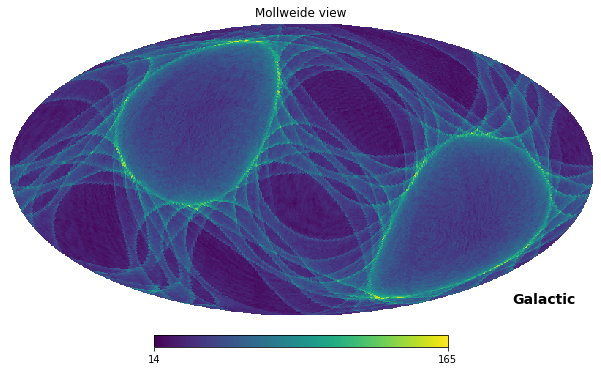

In [27]:
import healpy as hp
import numpy as np
hp.mollview(np.array(result), coord='eg')